In [1]:

!pip install wikipedia

In [2]:
# %load ../../load_magic/storage1.py

current_directory = !echo %cd%
folder_list = current_directory[0].split('\\')
%run ../../load_magic/storage2.py {len(folder_list) - folder_list.index('ipynb')}
%who

data_folder = ../data/
saves_folder = ../saves/
attempt_to_pickle	 current_directory	 data_folder	 encoding	 folder_list	 load_csv	 load_dataframes	 load_object	 os	 
pd	 pickle	 save_dataframes	 saves_folder	 store_objects	 sys	 


In [3]:

import numpy as np

# Convert [-500, 0, 500, 1000, 1500, 2000] into [-500, 1750, ... 2000]
nominal_list = [-500, 0, 500, 1000, 1500, 2000]
xtick_list = [int(round(elem)) for elem in pd.cut(np.array([1750, 2000]), 4, retbins=True)[1]]
xtick_list = [-500] + xtick_list
def recalculate_born_year(born_year):
    if born_year < nominal_list[1]:
        pass
    elif born_year < xtick_list[1]:
        born_year = born_year - (xtick_list[1] - nominal_list[1])
    elif born_year < xtick_list[2]:
        born_year = born_year - (xtick_list[2] - nominal_list[2])
    elif born_year < xtick_list[3]:
        born_year = born_year - (xtick_list[3] - nominal_list[3])
    elif born_year < xtick_list[4]:
        born_year = born_year - (xtick_list[4] - nominal_list[4])
    
    return born_year

In [4]:
from bs4 import BeautifulSoup as bs
import networkx as nx
import wikipedia
import re
from random import shuffle

jung_digraph = nx.DiGraph()
jung_title = 'Carl Jung'
node_list = [jung_title]
jung_digraph.add_node(jung_title)
jung_page = wikipedia.page(jung_title)
born_regex = re.compile(r'(\d{3,4}( BC)?)')
bc_regex = re.compile(r'(\d+) BC')
pos_dict = {}
y_supply = list(range(100))
shuffle(y_supply)

In [5]:

def y():
    
    return (y_supply.pop())

In [6]:

def spider_infoboxes(jung_digraph, jung_page, updown='both'):
    jung_soup = bs(jung_page.html(), 'lxml')
    jung_title = jung_page.title
    for param_th in jung_soup.find_all('th', scope='row'):
        if (param_th.text.strip()=='Baptised') or (param_th.text.strip()=='Born'):
            born_td = param_th.find_next_sibling('td')
            born_list = born_regex.findall(born_td.text)
            if len(born_list) > 0:
                born_x = max(born_list, key=lambda x: len(x[0]))[0]
                born_x = int(bc_regex.sub(r'-\1', born_x))
                born_x = recalculate_born_year(born_x)
                born_pos = np.array((born_x, y()))
                born_pos = born_pos.astype(np.float32)
                pos_dict[jung_title] = born_pos
        if (param_th.text.strip()=='Influences') and ((updown=='both') or (updown=='up')):
            influences_td = param_th.find_next_sibling('td')
            for influences_link in influences_td.find_all('a', title=True):
                influences_title = influences_link['title']
                
                # Compensate for redirects
                influences_page = wikipedia.page(influences_title)
                influences_title = influences_page.title
                
                if influences_title not in node_list:
                    jung_digraph.add_node(influences_title)
                jung_digraph.add_edge(influences_title, jung_title)
                if influences_title not in node_list:
                    jung_digraph = spider_infoboxes(jung_digraph, influences_page, updown='up')
                    node_list.append(influences_title)
        if (param_th.text.strip()=='Influenced') and ((updown=='both') or (updown=='down')):
            influenced_td = param_th.find_next_sibling('td')
            for influenced_link in influenced_td.find_all('a', title=True):
                influenced_title = influenced_link['title']
                
                # Compensate for redirects
                influenced_page = wikipedia.page(influenced_title)
                influenced_title = influenced_page.title
                
                if influenced_title not in node_list:
                    jung_digraph.add_node(influenced_title)
                jung_digraph.add_edge(jung_title, influenced_title)
                if influenced_title not in node_list:
                    jung_digraph = spider_infoboxes(jung_digraph, influenced_page, updown='down')
                    node_list.append(influenced_title)
    
    return jung_digraph

In [7]:

jung_digraph = spider_infoboxes(jung_digraph, jung_page)
store_objects(jung_digraph=jung_digraph)

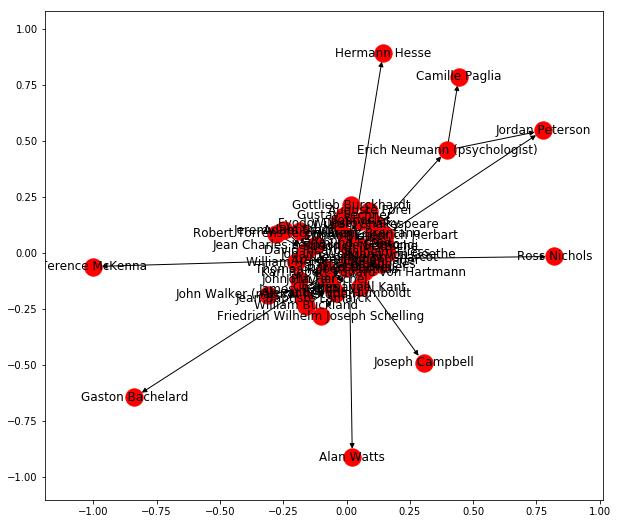

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

# Draw the graph using the default spring layout
plt.figure(figsize=(10,9))
nx.draw_networkx(jung_digraph)

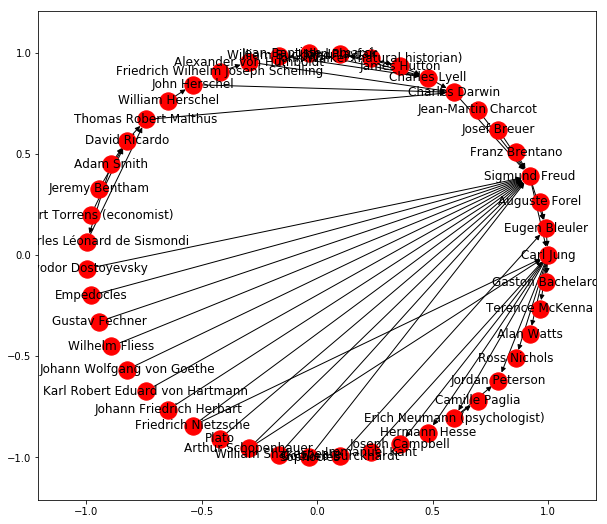

In [9]:

# Draw the graph using the circular layout
plt.figure(figsize=(10,9))
pos = nx.circular_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

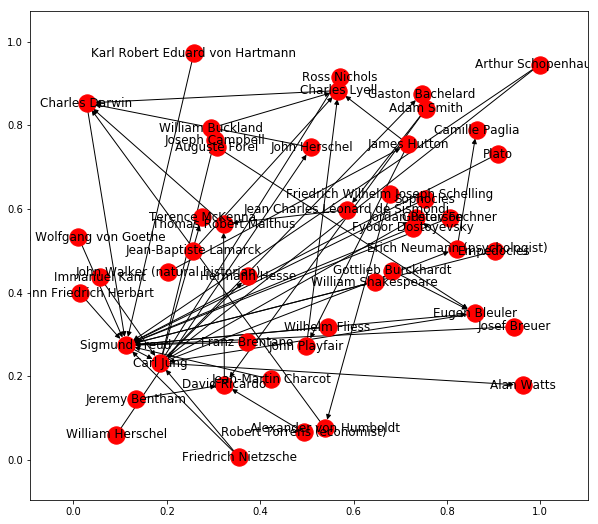

In [10]:

# Draw the graph using the random layout
plt.figure(figsize=(10,9))
pos = nx.random_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

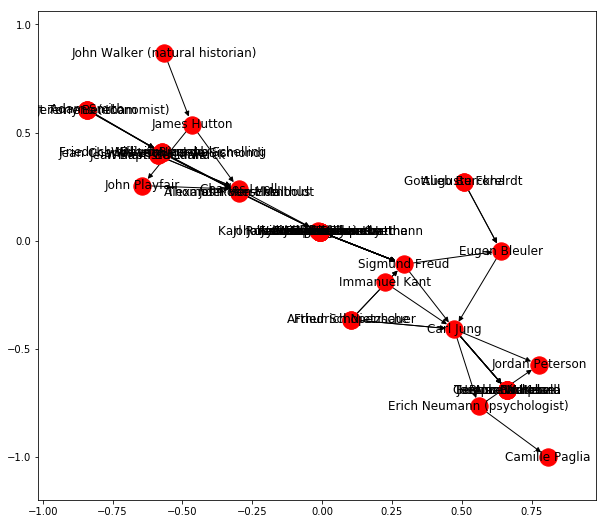

In [11]:

# Draw the graph using the kamada kawai layout
plt.figure(figsize=(10,9))
pos = nx.kamada_kawai_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

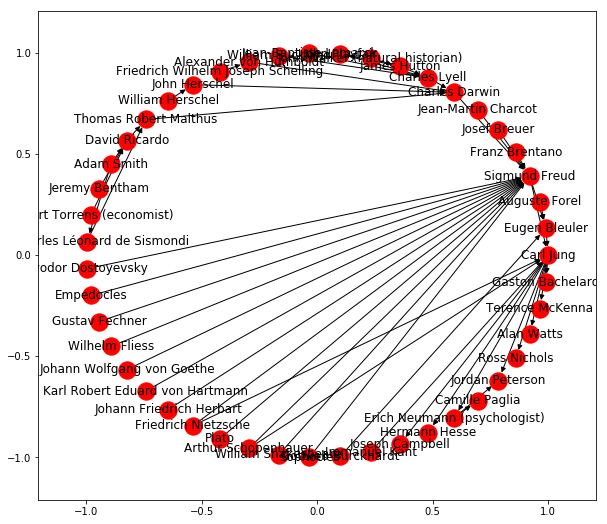

In [12]:

# Draw the graph using the shell layout
plt.figure(figsize=(10,9))
pos = nx.shell_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

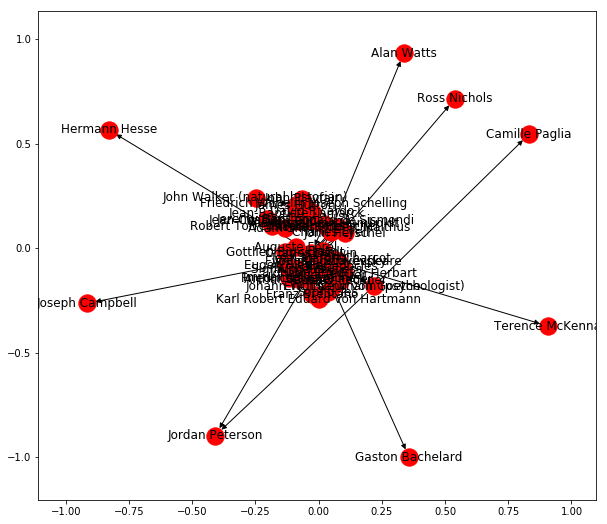

In [13]:

# Draw the graph using the spring layout
plt.figure(figsize=(10,9))
pos = nx.spring_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

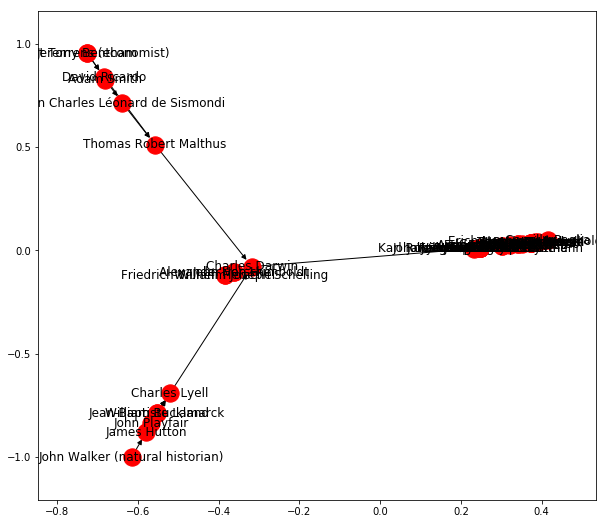

In [14]:

# Draw the graph using the spectral layout
plt.figure(figsize=(10,9))
pos = nx.spectral_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

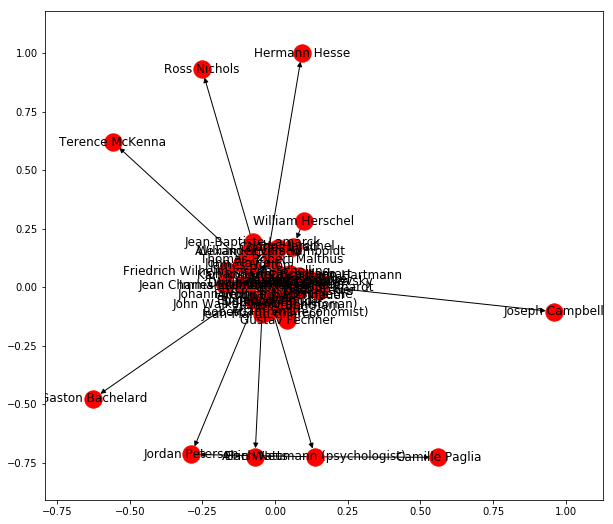

In [15]:

# Draw the graph using the fruchterman reingold layout
plt.figure(figsize=(10,9))
pos = nx.fruchterman_reingold_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

In [16]:

#pos_dict = load_object('pos_dict')
kamada_kawai_pos = nx.kamada_kawai_layout(jung_digraph)
for node in pos_dict:
    pos_dict[node] = np.array((pos_dict[node][0], kamada_kawai_pos[node][1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['Sophocles', 'Empedocles', 'Plato']


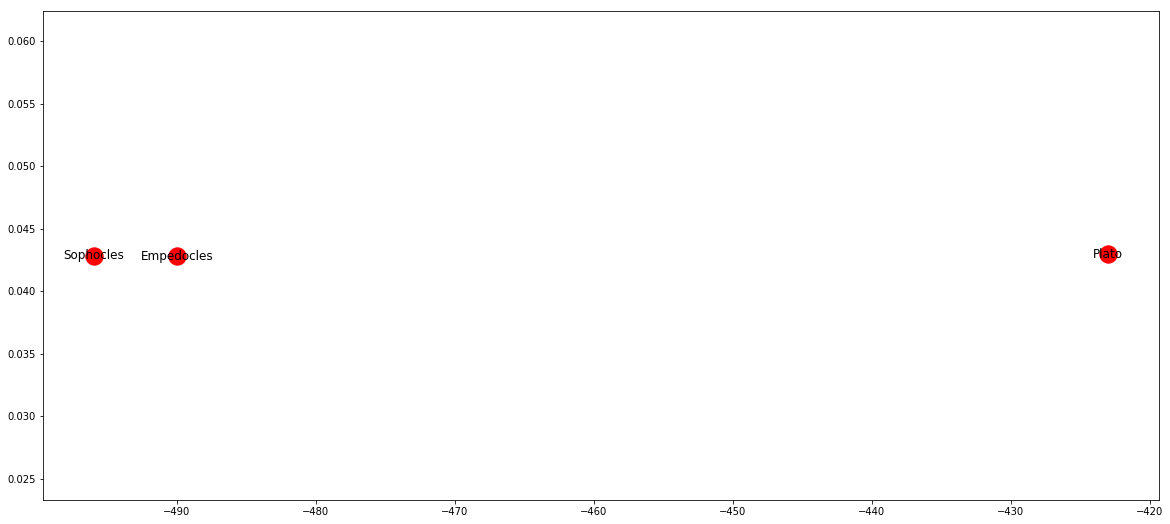

In [17]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[:3]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [18]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['William Shakespeare', 'Adam Smith', 'Immanuel Kant', 'James Hutton', 'John Walker (natural historian)', 'William Herschel', 'Jean-Baptiste Lamarck', 'John Playfair', 'Jeremy Bentham', 'Johann Wolfgang von Goethe']


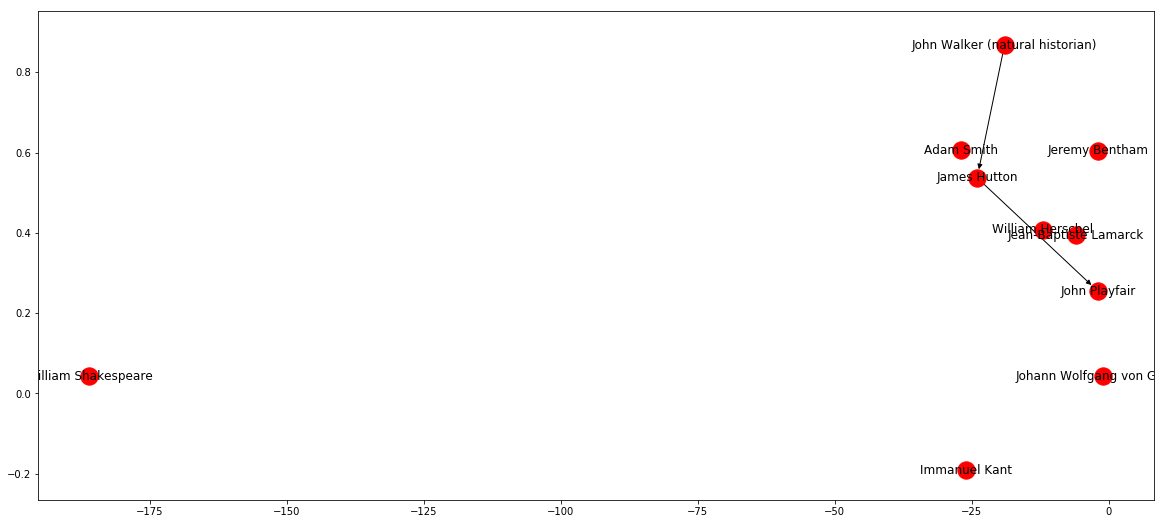

In [19]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[3:13]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [20]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['Thomas Robert Malthus', 'Alexander von Humboldt', 'David Ricardo', 'Jean Charles Léonard de Sismondi', 'Friedrich Wilhelm Joseph Schelling', 'Johann Friedrich Herbart', 'Robert Torrens (economist)', 'William Buckland', 'Arthur Schopenhauer', 'John Herschel', 'Charles Lyell', 'Gustav Fechner', 'Charles Darwin']


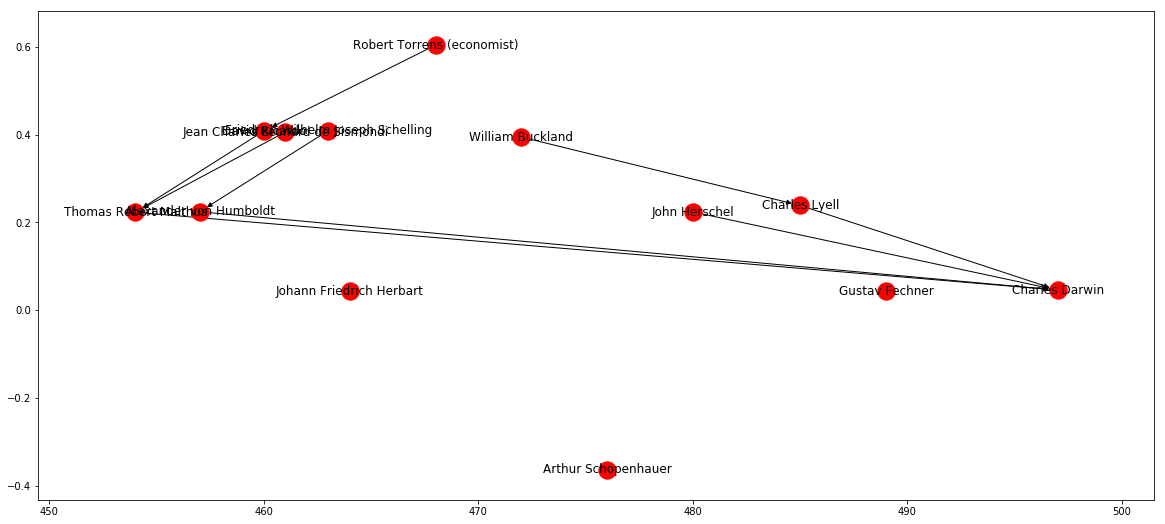

In [22]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[13:26]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [23]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['Fyodor Dostoyevsky', 'Jean-Martin Charcot', 'Gottlieb Burckhardt', 'Franz Brentano', 'Josef Breuer', 'Karl Robert Eduard von Hartmann', 'Friedrich Nietzsche', 'Auguste Forel', 'Sigmund Freud', 'Eugen Bleuler', 'Wilhelm Fliess']


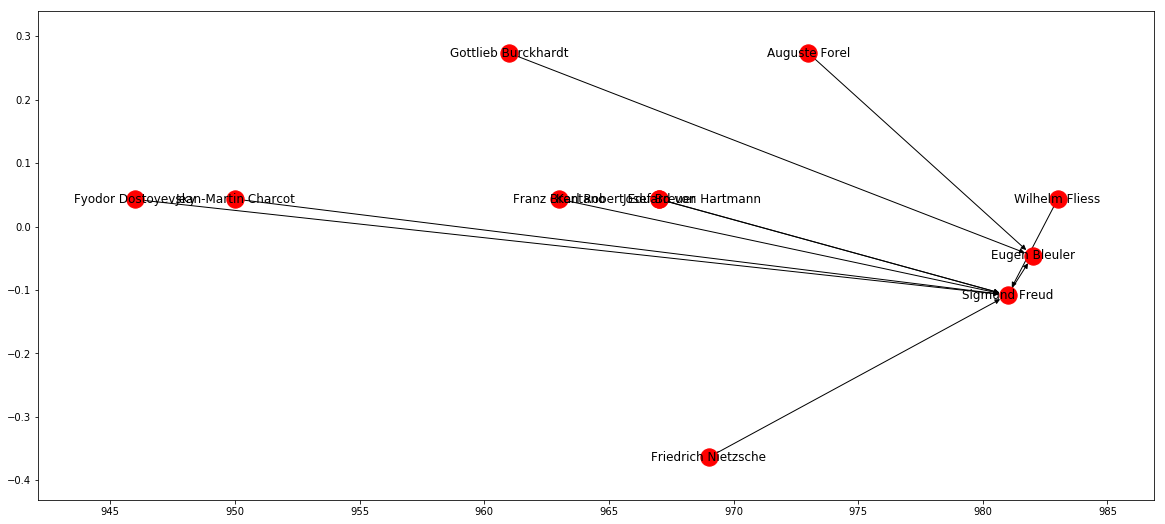

In [24]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[26:37]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [25]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['Carl Jung', 'Hermann Hesse', 'Gaston Bachelard', 'Ross Nichols', 'Joseph Campbell', 'Erich Neumann (psychologist)', 'Alan Watts']


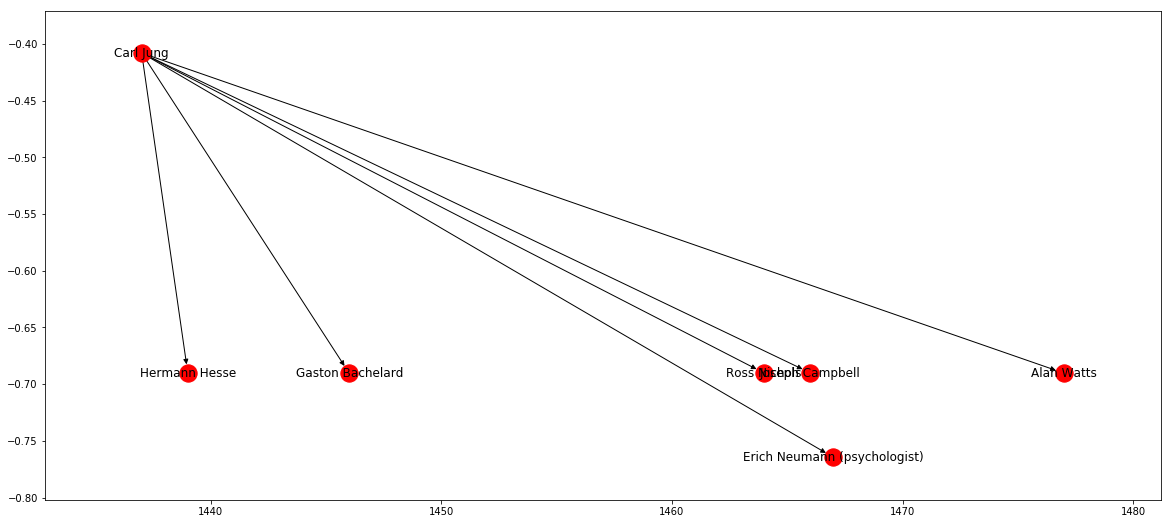

In [26]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[37:44]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [27]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

['Terence McKenna', 'Camille Paglia', 'Jordan Peterson']


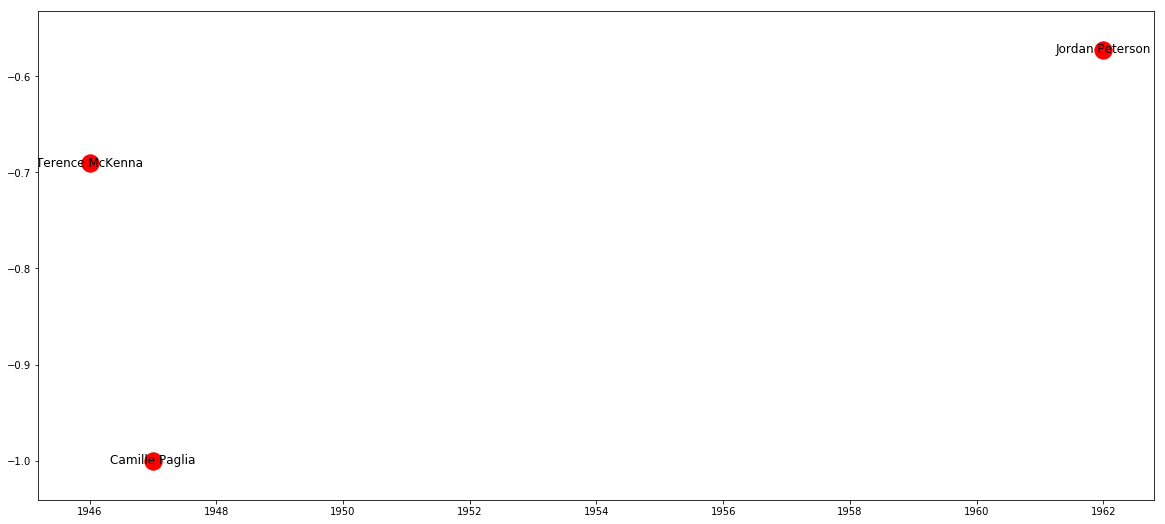

In [28]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Let's look at dudes based on their birth range
tuple_list = sorted(pos_dict.items(), key=lambda x: x[1][0])[44:47]
jung_digraph = load_object('jung_digraph')
node_list = [node[0] for node in tuple_list]
jung_subgraph = jung_digraph.subgraph(node_list)
subgraph_fig = plt.figure(figsize=(20, 9))
subgraph_ax = subgraph_fig.add_subplot(111)
nx.draw_networkx(G=jung_subgraph, pos=pos_dict)
print(str(node_list))

In [29]:

cut_array = pd.cut(np.array([-1.5, 1.5]), len(node_list)+1, retbins=True)[1]
for i, node in enumerate(node_list):
    pos_dict[node] = np.array((pos_dict[node][0], cut_array[i+1])).astype(np.float32)
store_objects(pos_dict=pos_dict)

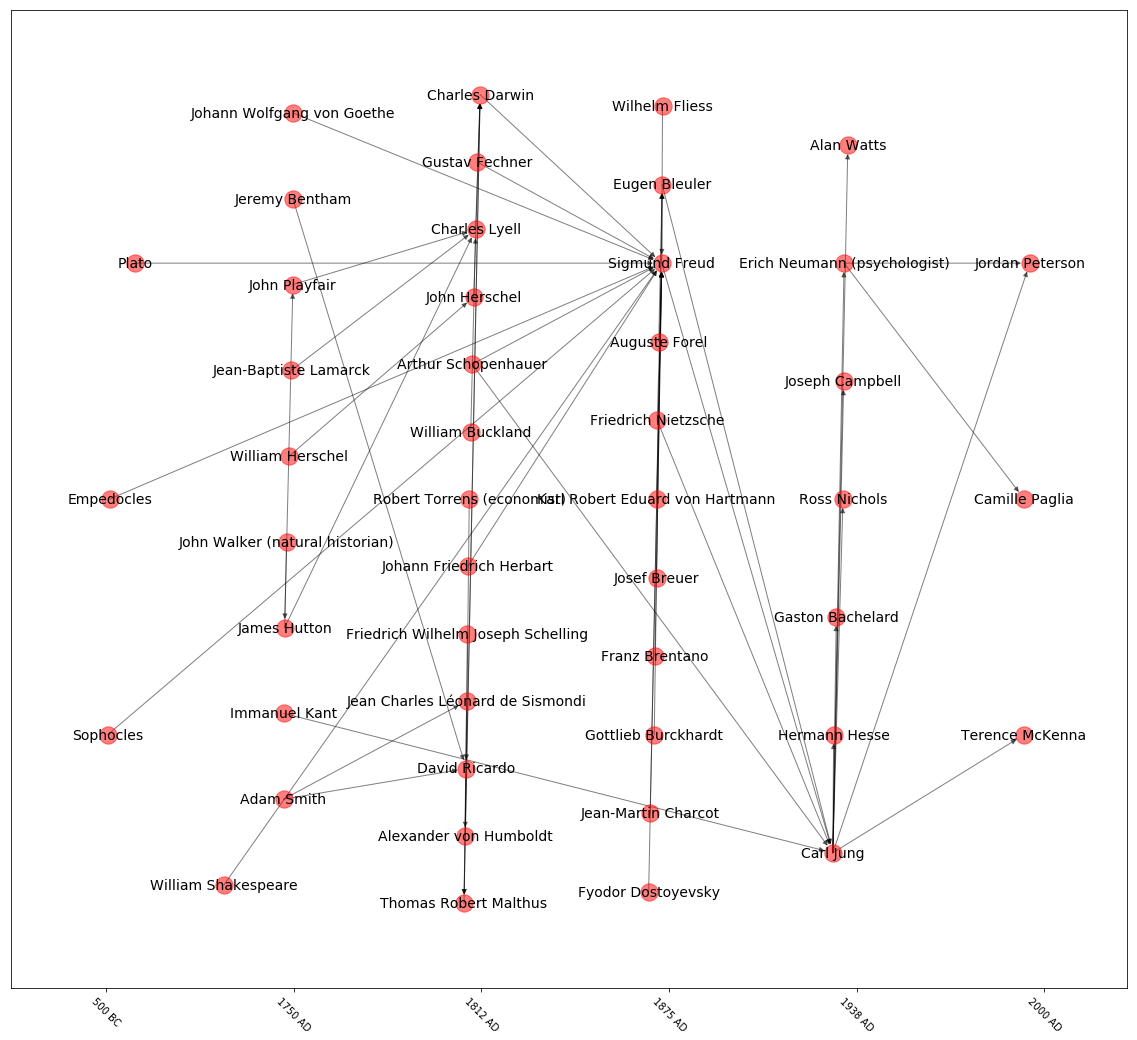

In [30]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Draw the graph using the birth-year-based layout
pos_dict = load_object('pos_dict')
jung_fig = plt.figure(figsize=(20, 18))
ax = jung_fig.add_subplot(111)
xticklabel_list = []
bc_regex = re.compile(r'-(\d+)')
for xtick in xtick_list:
    if xtick == 0:
        xticklabel_list.append('')
    elif xtick < 0:
        xticklabel_list.append(bc_regex.sub(r'\1 BC', str(xtick)))
    elif xtick > 0:
        xticklabel_list.append(str(xtick) + ' AD')
plt.xticks(nominal_list, xticklabel_list, rotation=-45)
plt.yticks([], [])
jung_digraph = load_object('jung_digraph')
node_collection = nx.draw_networkx_nodes(G=jung_digraph, pos=pos_dict, alpha=0.5)
edge_collection = nx.draw_networkx_edges(G=jung_digraph, pos=pos_dict, alpha=0.5)
labels_collection = nx.draw_networkx_labels(G=jung_digraph, pos=pos_dict, font_size=14)

In [31]:

# https://www.reddit.com/r/Jung/comments/8105jh/i_scraped_wikipedia_to_build_jungian_influence/duzirxw/
for node in nx.all_neighbors(jung_digraph, 'Terence McKenna'):
    print(node)

Carl Jung


In [32]:

# https://www.reddit.com/r/Jung/comments/8105jh/i_scraped_wikipedia_to_build_jungian_influence/duzirxw/
for node in nx.all_neighbors(jung_digraph, 'Sigmund Freud'):
    print(node)

Franz Brentano
Josef Breuer
Jean-Martin Charcot
Charles Darwin
Fyodor Dostoyevsky
Empedocles
Gustav Fechner
Wilhelm Fliess
Johann Wolfgang von Goethe
Karl Robert Eduard von Hartmann
Johann Friedrich Herbart
Friedrich Nietzsche
Plato
Arthur Schopenhauer
William Shakespeare
Sophocles
Eugen Bleuler
Carl Jung


In [33]:

trb_title = 'Thomas Robert Malthus'
trb_page = wikipedia.page(trb_title)
print(trb_page.title)
trb_soup = bs(trb_page.html(), 'lxml')
print(trb_soup.title)

Thomas Robert Malthus
None


In [34]:

tb_title = 'Thomas Malthus'
tb_page = wikipedia.page(tb_title)
print(tb_page.title)
tb_soup = bs(tb_page.html(), 'lxml')
print(tb_soup.title)

Thomas Robert Malthus
None


In [35]:

dict(nx.shortest_path_length(jung_digraph))

{'Adam Smith': {'Adam Smith': 0,
  'Alan Watts': 6,
  'Camille Paglia': 7,
  'Carl Jung': 5,
  'Charles Darwin': 3,
  'David Ricardo': 1,
  'Erich Neumann (psychologist)': 6,
  'Eugen Bleuler': 5,
  'Gaston Bachelard': 6,
  'Hermann Hesse': 6,
  'Jean Charles Léonard de Sismondi': 1,
  'Jordan Peterson': 6,
  'Joseph Campbell': 6,
  'Ross Nichols': 6,
  'Sigmund Freud': 4,
  'Terence McKenna': 6,
  'Thomas Robert Malthus': 2},
 'Alan Watts': {'Alan Watts': 0},
 'Alexander von Humboldt': {'Alan Watts': 4,
  'Alexander von Humboldt': 0,
  'Camille Paglia': 5,
  'Carl Jung': 3,
  'Charles Darwin': 1,
  'Erich Neumann (psychologist)': 4,
  'Eugen Bleuler': 3,
  'Gaston Bachelard': 4,
  'Hermann Hesse': 4,
  'Jordan Peterson': 4,
  'Joseph Campbell': 4,
  'Ross Nichols': 4,
  'Sigmund Freud': 2,
  'Terence McKenna': 4},
 'Arthur Schopenhauer': {'Alan Watts': 2,
  'Arthur Schopenhauer': 0,
  'Camille Paglia': 3,
  'Carl Jung': 1,
  'Erich Neumann (psychologist)': 2,
  'Eugen Bleuler': 2,
  '

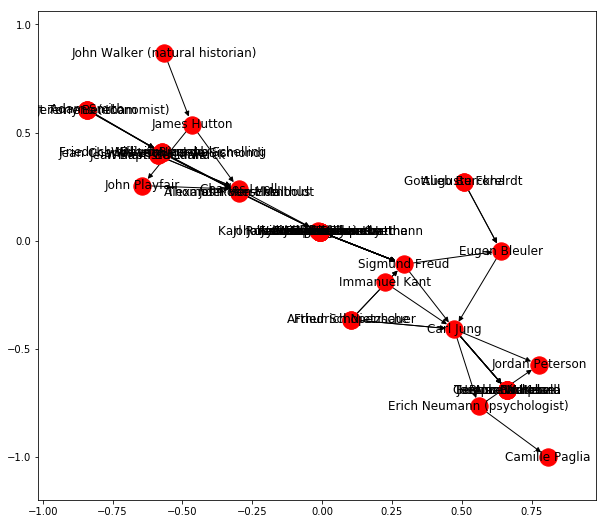

In [36]:

# Draw the graph using the kamada kawai layout
plt.figure(figsize=(10,9))
pos = nx.kamada_kawai_layout(jung_digraph)
nx.draw_networkx(jung_digraph, pos)

In [41]:

rows_list = []
for key, value in pos.items():
    
    # Get input row in dictionary format; key = col_name
    row_dict = {}
    row_dict['node'] = key
    row_dict['x'] = value[0]
    row_dict['y'] = value[1]
    
    rows_list.append(row_dict)

kamada_kawai_df = pd.DataFrame(rows_list, columns=['node', 'x', 'y'])
kamada_kawai_df.sample(n=15)

,node,x,y
18,Thomas Robert Malthus,-0.298301,0.223229
36,Gottlieb Burckhardt,0.506923,0.273360
37,Immanuel Kant,0.225376,-0.191972
26,Gustav Fechner,-0.007349,0.042903
17,William Herschel,-0.573301,0.407868
10,John Walker (natural historian),-0.564867,0.867936
21,Jeremy Bentham,-0.842228,0.604732
13,William Buckland,-0.588027,0.394751
8,Charles Lyell,-0.298562,0.238750
9,James Hutton,-0.466489,0.537371


In [63]:

def fsi_numpy(item_id):
    tmp_arr = elite_ndarray - elite_ndarray[item_id]
    tmp_ser = np.sum(np.square(tmp_arr), axis=1)
    
    return tmp_ser

In [64]:

elite_df.head(5)

,node,x,y
0,Carl Jung,0.472683,-0.407949
1,Eugen Bleuler,0.640368,-0.046264
2,Auguste Forel,0.507592,0.273523
3,Sigmund Freud,0.291561,-0.108111
4,Franz Brentano,-0.007148,0.043199


In [66]:

elite_df['dist2Carl_Jung'] = fsi_numpy(0)
elite_df.sort_values('dist2Carl_Jung').head(10)

,node,x,y,dist2Carl_Jung
0,Carl Jung,0.472683,-0.407949,0.000000
37,Immanuel Kant,0.225376,-0.191972,0.107807
38,Joseph Campbell,0.662564,-0.690049,0.115635
39,Hermann Hesse,0.662523,-0.690083,0.115639
43,Ross Nichols,0.662362,-0.690215,0.115652
44,Alan Watts,0.662327,-0.690245,0.115655
45,Terence McKenna,0.662287,-0.690278,0.115659
46,Gaston Bachelard,0.662234,-0.690321,0.115664
42,Jordan Peterson,0.776674,-0.572276,0.119414
3,Sigmund Freud,0.291561,-0.108111,0.122708


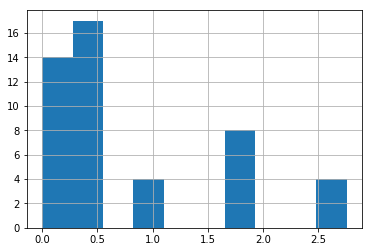

In [67]:

elite_df['dist2Carl_Jung'].hist()

17 [ 0  1  2  3  4  4  4  4  5  6  7  8  9  9  5  9  5  9  5  9 10 10 10  9
  4  4  4  4  4  4  4 11  4 11  4  4  2 12 13 13 14 15 16 13 13 13 13]


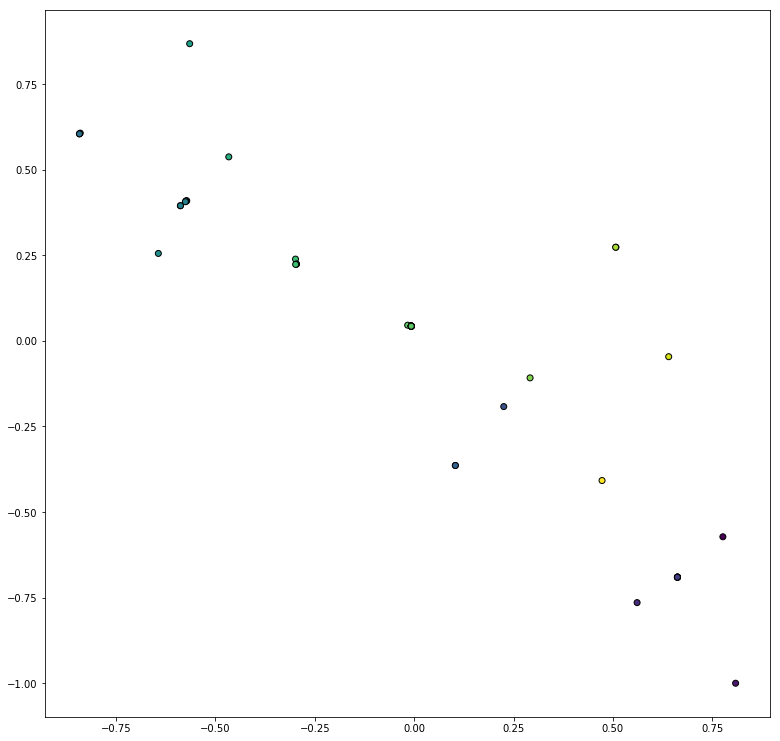

In [76]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

elite_df = kamada_kawai_df.dropna(how='any').copy()
column_list = ['x', 'y']
elite_ndarray = elite_df[column_list].as_matrix()

# Compute DBSCAN

# The maximum distance between two samples for them to be considered
# as in the same neighborhood.
eps = .03

# The number of samples (or total weight) in a neighborhood for a point
# to be considered as a core point. This includes the point itself.
min_samples = 1

db = DBSCAN(eps=eps, min_samples=min_samples).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             c=labels,
                             edgecolors=(0, 0, 0), cmap=cmap)

# Looking for 17 clusters
print(len(set(labels)), labels)